# Введение


Подключение библиотек

In [1]:
import pandas as pd
import math
import numpy as np
import csv
import scipy.optimize, scipy.integrate
from matplotlib import pyplot as plt
from scipy.stats import norm
import random
import numpy as np
from scipy.integrate import trapezoid
import seaborn as sns

# Формирование базы данных (спектр - глубинка)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Функция Ландау

In [3]:
def lambdau10(x):
    _lambdau = lambda t, x: np.exp(-t)*np.cos(t*x + 2*t/np.pi*np.log(t))
    res = np.array(scipy.integrate.quad(_lambdau, 0, np.inf, args=(x,)))
    res[0] /= np.pi
    return res
try:
    _landau10_y, _landau10_x
except:
    print("Initializing Landau10)")
    _landau10_x = np.linspace(-30, 30, int(3e3))
    _landau10_y = np.array([lambdau10(i) for i in _landau10_x])[:,0]


def spec(e, a, b, E0):
    return a * Landau10((E0 - e) / b)/b

def distr(df_mono,spec):
    ar_mono = df_mono.to_numpy()
    return np.matmul(ar_mono, spec)


Landau10 = lambda x: np.interp(x, _landau10_x, _landau10_y)

Initializing Landau10)


<ipython-input-3-62fea05f6edf>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res = np.array(scipy.integrate.quad(_lambdau, 0, np.inf, args=(x,)))


##Функция Гаусса

Задаем фукнцию Гаусса
**x** - вектор энергии
**mu** - среднее значение
**sigma** - стандартное отклонение
**a** - амплитуда

In [4]:

def gauss(x, a, sigma, mu):
  gauss = a*np.exp(-((x-mu)**2)/(2*(sigma)**2))/(sigma*(2*np.pi)**(1/2))

  return gauss



def gauss_mult(x,a,sigma, mu, peaks):
  if peaks ==1:
    ans = gauss(x,a,sigma, mu)
  elif peaks == 2:
    a1 = random.random()
    a2 = 1 - a1
    a0 = [a1, a2]
    a0.sort()

    mu2 = mu*(1 - abs(np.random.normal(0.2, 0.1)))
    sigma2 = random.uniform(0.1, 2)
    ans = gauss(x,a0[0],sigma2, mu2) + gauss(x,a0[1],sigma, mu)


  return ans/max(ans)




In [5]:

df_mono_WATER = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Спектры/tables/DB_WATER1.xls', index_col=0)

a = 1
e_gs = np.linspace(1,19.9, 380)
e = np.linspace(1,19.9, 190)

def mono_land(a,b):
  mono_land = []
  for E0 in np.linspace(1, 19.9, 380):
    sp = spec(e, a, b, E0).tolist()
    mono_land.append(sp)

  return np.array(mono_land)


In [ ]:
dataSPDIS = pd.DataFrame(columns = ['gauss', 'spec', 'distr'])


for i in range(100000):

  sigma = random.uniform(0.05, 1)
  b = random.uniform(0.05, 1)
  mu = random.choice([a/10 for a in range(10,200)])
  peaks = random.randint(1,2)

  gs = gauss_mult(e_gs, a, sigma, mu, peaks)

  land_mx = mono_land(a,b)

  sp0 = np.matmul(gs, land_mx)
  sp0 = sp0/max(sp0)
  ds0 = distr(df_mono_WATER, sp0)/distr(df_mono_WATER, sp0)[0]

  dataSPDIS.loc[i] = [gs, sp0, ds0]


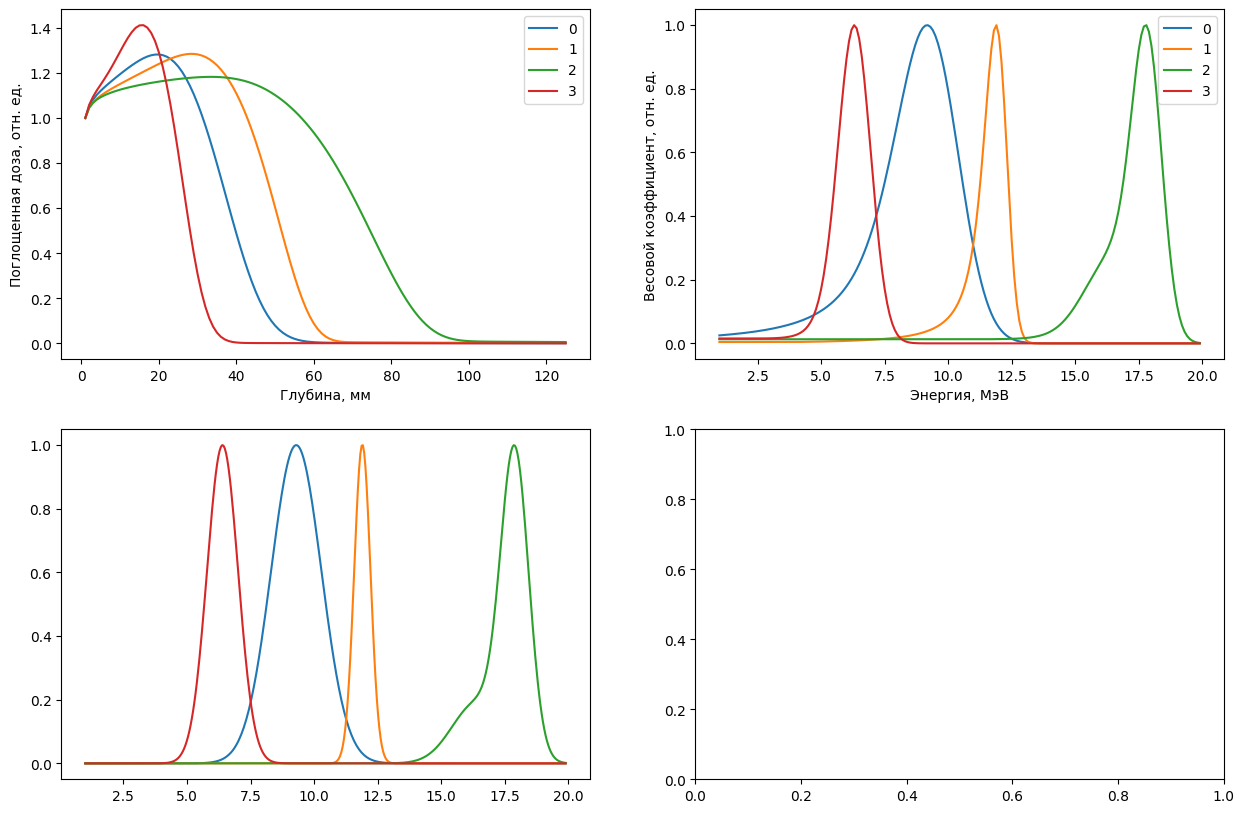

In [ ]:
idx_viz = [random.randint(0, 100) for i in range(20)]

e = np.linspace(1,19.9,190)



fig, axs = plt.subplots(2,2, figsize = (15,10))

axs[0,1].plot(e,dataSPDIS['spec'][idx_viz[0]], label='0')
axs[0,1].plot(e,dataSPDIS['spec'][idx_viz[1]], label = '1')
axs[0,1].plot(e,dataSPDIS['spec'][idx_viz[13]], label = '2')
axs[0,1].plot(e,dataSPDIS['spec'][idx_viz[3]], label = '3')


axs[0,1].set_xlabel('Энергия, МэВ')
axs[0,1].set_ylabel('Весовой коэффициент, отн. ед.')
axs[0,1].legend()

axs[0,0].plot(np.linspace(1,125,125), dataSPDIS['distr'][idx_viz[0]], label='0')
axs[0,0].plot(np.linspace(1,125,125), dataSPDIS['distr'][idx_viz[1]], label='1')
axs[0,0].plot(np.linspace(1,125,125), dataSPDIS['distr'][idx_viz[13]], label='2')
axs[0,0].plot(np.linspace(1,125,125), dataSPDIS['distr'][idx_viz[3]], label='3')

axs[0,0].set_xlabel('Глубина, мм')
axs[0,0].set_ylabel('Поглощенная доза, отн. ед.')
axs[0,0].legend()

axs[1,0].plot(e_gs,dataSPDIS['gauss'][idx_viz[0]], label='0')
axs[1,0].plot(e_gs,dataSPDIS['gauss'][idx_viz[1]], label = '1')
axs[1,0].plot(e_gs,dataSPDIS['gauss'][idx_viz[13]], label = '2')
axs[1,0].plot(e_gs,dataSPDIS['gauss'][idx_viz[3]], label = '3')

plt.show()

In [23]:
data = {}
for col in ['gauss', 'spec', 'distr']:
  data[col] = np.array(dataSPDIS[col].to_list())

np.savez('output_100k_narrow', **data)

NameError: name 'dataSPDIS' is not defined

In [24]:
data_npz = np.load('/content/drive/My Drive/Colab Notebooks/Спектры/tables/output_100k_narrow.npz')
gauss_np = data_npz['gauss']
spec_np = data_npz['spec']
distr_np = data_npz['distr']



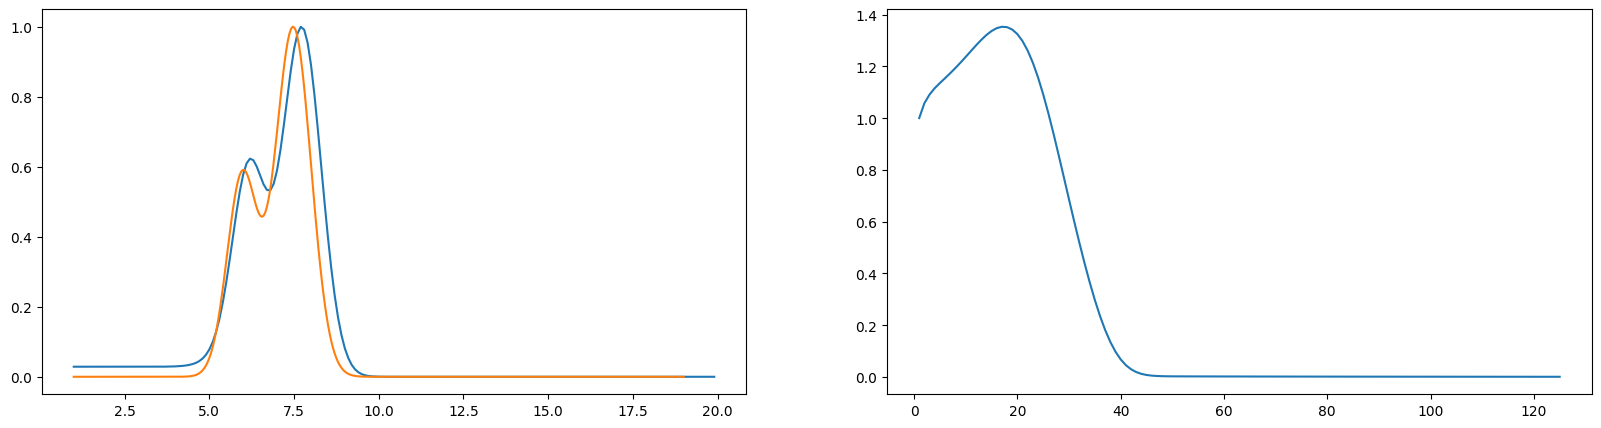

In [26]:

idx = 1111

fig, axs = plt.subplots(1, 2, figsize = (20,5))

axs[0].plot(np.linspace(1, 19.9, 190), spec_np[idx])
axs[0].plot(np.linspace(1, 19, 380), gauss_np[idx])

axs[1].plot(np.linspace(1,125,125), distr_np[idx])


plt.show()

# Кластеризация

In [27]:
spec_np.shape

(100000, 190)

In [28]:
spec_np_mean = spec_np*e
spec_np_mean = np.sum(spec_np_mean, axis=1)/np.sum(spec_np, axis=1)
spec_np_max = np.array([np.where(a == max(a))[0].item()/10 for a in spec_np])
spec_np_weight = np.max(spec_np,axis = 1)


gauss_np_mean = gauss_np*e_gs
gauss_np_mean = np.sum(gauss_np_mean, axis=1)/np.sum(gauss_np, axis=1)
gauss_np_max = np.array([np.where(a == max(a))[0].item()/20 for a in gauss_np])
gauss_np_weight = np.max(gauss_np,axis = 1)


spec_class = np.vstack((spec_np_mean,spec_np_max))
gauss_class = np.vstack((gauss_np_mean,gauss_np_max))
spec_class_weight = np.vstack((spec_np_max, spec_np_weight ))
gauss_class_weight = np.vstack((gauss_np_max, gauss_np_weight ))


spec_class = np.transpose(spec_class)[0:5000]
gauss_class = np.transpose(gauss_class)[0:5000]
spec_class_weight = np.transpose(spec_class_weight)[0:5000]
gauss_class_weight = np.transpose(gauss_class_weight)[0:5000]


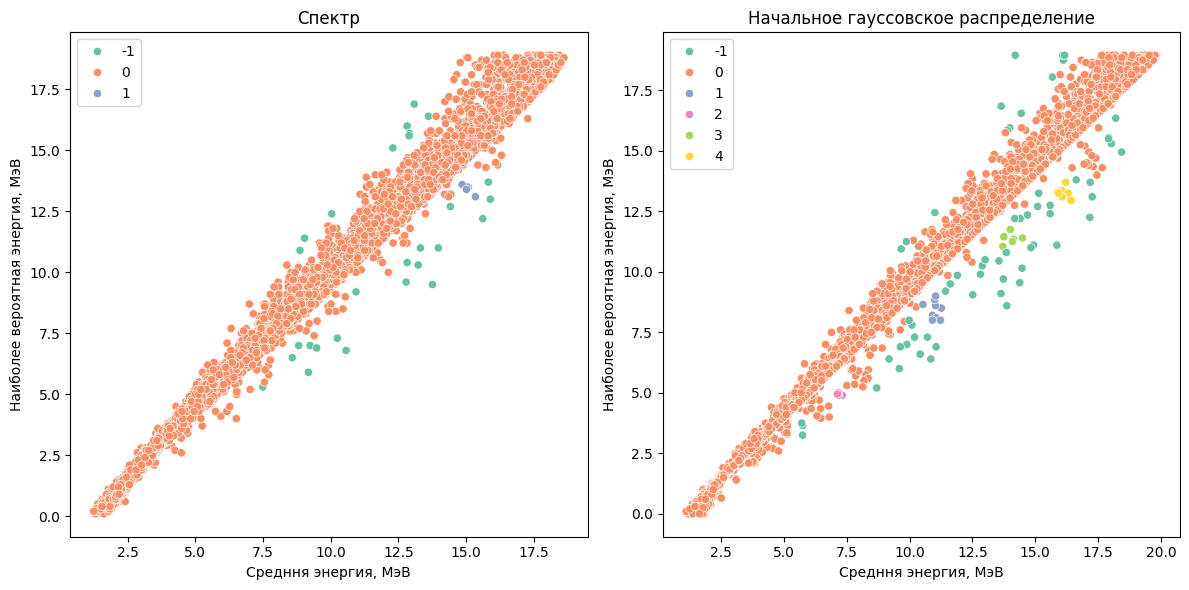

In [67]:
from sklearn.cluster import DBSCAN


def plot_dbscan_clustering(ax, data, eps, min_samples, title):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)

    sns.scatterplot(
        x=data[:, 0], y=data[:, 1], hue=dbscan_labels, palette="Set2", ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Средння энергия, МэВ")
    ax.set_ylabel("Наиболее вероятная энергия, МэВ")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_dbscan_clustering(
    axes[0], spec_class, eps=0.5, min_samples=5, title="Спектр"
)
plot_dbscan_clustering(
    axes[1], gauss_class, eps=0.5, min_samples=5, title="Начальное гауссовское распределение"
)

plt.tight_layout()
plt.show()

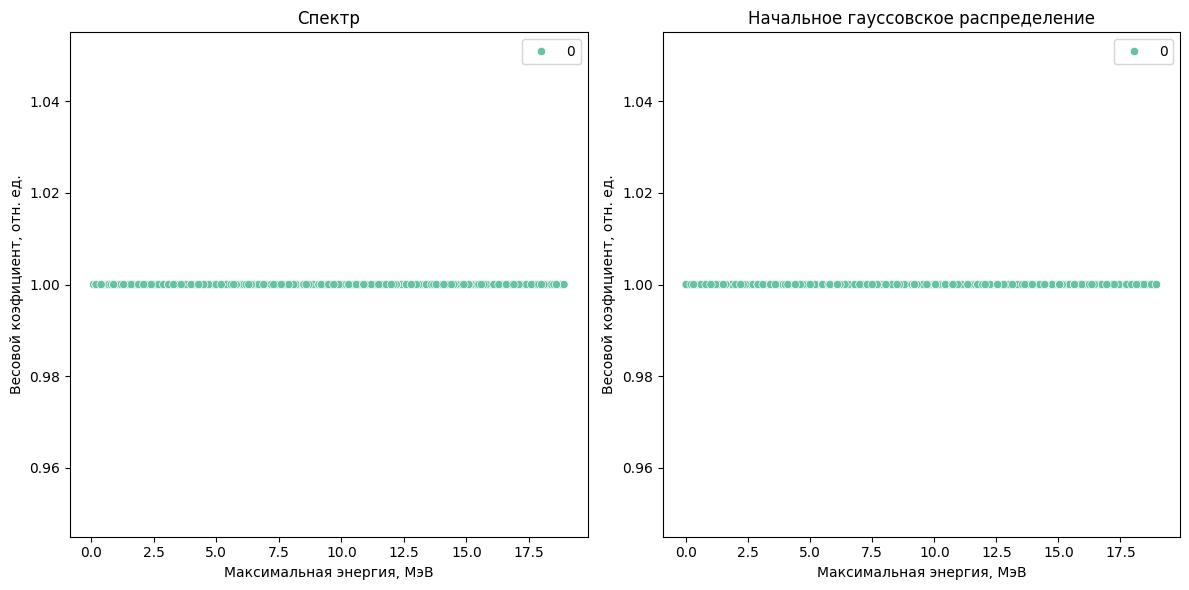

In [31]:
from sklearn.cluster import DBSCAN


def plot_dbscan_clustering(ax, data, eps, min_samples, title):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)

    sns.scatterplot(
        x=data[:, 0], y=data[:, 1], hue=dbscan_labels, palette="Set2", ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Максимальная энергия, МэВ")
    ax.set_ylabel("Весовой коэфициент, отн. ед.")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_dbscan_clustering(
    axes[0], spec_class_weight, eps=0.5, min_samples=5, title="Спектр"
)
plot_dbscan_clustering(
    axes[1], gauss_class_weight, eps=0.5, min_samples=5, title="Начальное гауссовское распределение"
)

plt.tight_layout()
plt.show()

#Аугментация

In [32]:

class GNoise:

    def __init__(self, sigma=0.01):
        self.sigma = sigma  # noise level

    def __call__(self, spec):

        spec_noise = np.random.normal(spec, self.sigma)

        return spec_noise

In [63]:
from torchvision.transforms import v2

gn = v2.RandomApply(
    transforms=[
       GNoise(sigma=0.02)
    ],
    p=0.5,
)

In [64]:
x = np.linspace(0,125,125)

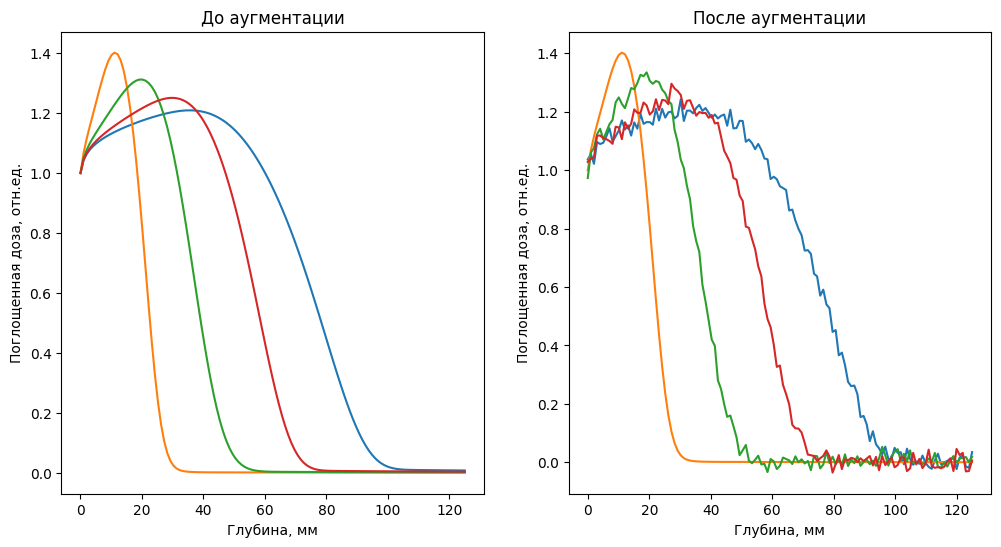

In [66]:
from operator import index
idx = [random.randint(0, 1000) for i in range(20)]


SN1 = gn(distr_np[idx[1]])
SN2 = gn(distr_np[idx[2]])
SN3 = gn(distr_np[idx[3]])
SN4 = gn(distr_np[idx[4]])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(x, distr_np[idx[1]])
axes[0].plot(x, distr_np[idx[2]])
axes[0].plot(x, distr_np[idx[3]])
axes[0].plot(x, distr_np[idx[4]])
axes[0].set_title('До аугментации')
axes[0].set_xlabel('Глубина, мм')
axes[0].set_ylabel('Поглощенная доза, отн.ед.')

axes[1]. plot(x,SN1)
axes[1]. plot(x,SN2)
axes[1]. plot(x,SN3)
axes[1]. plot(x,SN4)
axes[1].set_title('После аугментации')
axes[1].set_xlabel('Глубина, мм')
axes[1].set_ylabel('Поглощенная доза, отн.ед.')
plt.show()

In [6]:
exp_spec = np.array([-1.16220361e-03, -1.16219962e-03, -1.16219461e-03, -1.16218830e-03,
       -1.16218037e-03, -1.16217041e-03, -1.16215788e-03, -1.16214212e-03,
       -1.16212232e-03, -1.16209742e-03, -1.16206611e-03, -1.16202674e-03,
       -1.16197725e-03, -1.16191503e-03, -1.16183680e-03, -1.16173844e-03,
       -1.16161477e-03, -1.16145929e-03, -1.16126381e-03, -1.16101804e-03,
       -1.16070904e-03, -1.16032053e-03, -1.15983208e-03, -1.15921796e-03,
       -1.15844585e-03, -1.15747509e-03, -1.15625459e-03, -1.15472008e-03,
       -1.15279078e-03, -1.15036512e-03, -1.14731541e-03, -1.14348109e-03,
       -1.13866031e-03, -1.13259927e-03, -1.12497889e-03, -1.11539799e-03,
       -1.10335219e-03, -1.08820733e-03, -1.06916610e-03, -1.04522609e-03,
       -1.01512696e-03, -9.77284134e-04, -9.29705381e-04, -8.69885906e-04,
       -7.94676503e-04, -7.00117760e-04, -5.81231619e-04, -4.31759298e-04,
       -2.43831803e-04, -7.55566226e-06,  2.89507920e-04,  6.62997904e-04,
        1.13257673e-03,  1.72296545e-03,  2.46524516e-03,  3.39849332e-03,
        4.57184091e-03,  6.04705900e-03,  7.90181069e-03,  1.02337397e-02,
        1.31656107e-02,  1.68517727e-02,  2.14862841e-02,  2.73131296e-02,
        3.46390643e-02,  4.38497633e-02,  5.54301254e-02,  6.99898004e-02,
        8.82952848e-02,  1.11310274e-01,  1.40246395e-01,  1.76626996e-01,
        2.22367338e-01,  2.79875429e-01,  3.00346021e-01,  3.05882353e-01,
        3.05882353e-01,  3.05882353e-01,  3.07647059e-01,  3.13529412e-01,
        3.25077399e-01,  3.49845201e-01,  3.88235294e-01,  4.47058823e-01,
        5.21925134e-01,  6.34224599e-01,  7.46803069e-01,  8.61892583e-01,
        9.76982097e-01,  9.80392157e-01,  9.55882353e-01,  8.80000000e-01,
        7.60990920e-01,  5.48505618e-01,  3.95281341e-01,  2.84790503e-01,
        2.05114974e-01,  1.47660528e-01,  1.06229822e-01,  7.63539203e-02,
        5.48102494e-02,  3.92749941e-02,  2.80724392e-02,  1.99942174e-02,
        1.41689689e-02,  9.96835135e-03,  6.93926376e-03,  4.75497265e-03,
        3.17986874e-03,  2.04405297e-03,  1.22501020e-03,  6.34394117e-04,
        2.08497728e-04, -9.86184146e-05, -3.20081493e-04, -4.79779693e-04,
       -5.94938911e-04, -6.77980834e-04, -7.37862804e-04, -7.81044010e-04,
       -8.12182207e-04, -8.34636126e-04, -8.50827766e-04, -8.62503643e-04,
       -8.70923180e-04, -8.76994552e-04, -8.81372652e-04, -8.84529722e-04,
       -8.86806302e-04, -8.88447956e-04, -8.89631762e-04, -8.90485410e-04,
       -8.91100980e-04, -8.91544872e-04, -8.91864964e-04, -8.92095784e-04,
       -8.92262230e-04, -8.92382254e-04, -8.92468805e-04, -8.92531217e-04,
       -8.92576223e-04, -8.92608677e-04, -8.92632079e-04, -8.92648955e-04,
       -8.92661124e-04, -8.92669899e-04, -8.92676227e-04, -8.92680790e-04,
       -8.92684081e-04, -8.92686454e-04, -8.92688165e-04, -8.92689398e-04,
       -8.92690288e-04, -8.92690930e-04, -8.92691392e-04, -8.92691726e-04,
       -8.92691967e-04, -8.92692140e-04, -8.92692265e-04, -8.92692355e-04,
       -8.92692420e-04, -8.92692467e-04, -8.92692501e-04, -8.92692525e-04,
       -8.92692543e-04, -8.92692556e-04, -8.92692565e-04, -8.92692572e-04,
       -8.92692576e-04, -8.92692580e-04, -8.92692582e-04, -8.92692584e-04,
       -8.92692585e-04, -8.92692586e-04, -8.92692587e-04, -8.92692587e-04,
       -8.92692588e-04, -8.92692588e-04, -8.92692588e-04, -8.92692588e-04,
       -8.92692588e-04, -8.92692588e-04, -8.92692588e-04, -8.92692588e-04,
       -8.92692588e-04, -8.92692589e-04, -8.92692589e-04, -8.92692589e-04,
       -8.92692589e-04, -8.92692589e-04])

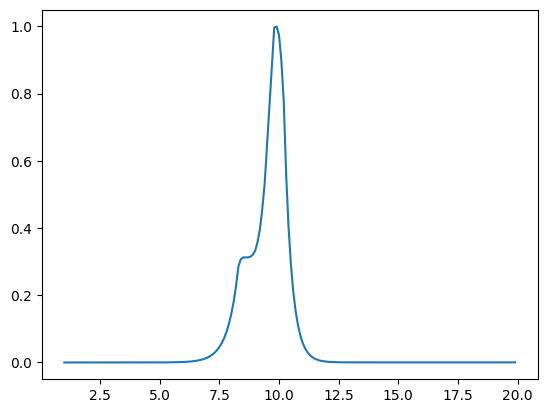

In [16]:
exp_spec = exp_spec/max(exp_spec)
plt.plot(e,exp_spec)

In [17]:
 ds0 = distr(df_mono_WATER, exp_spec)/distr(df_mono_WATER, exp_spec)[0]

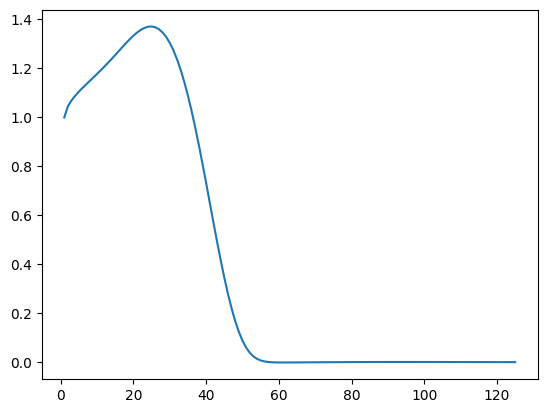

In [18]:
plt.plot(np.linspace(1,125,125), ds0)

In [19]:
data = {'spec': exp_spec , 'distr': ds0}


np.savez('exp_spec', **data)

In [20]:
data_npz = np.load('exp_spec.npz')

spec_np = data_npz['spec']
distr_np = data_npz['distr']

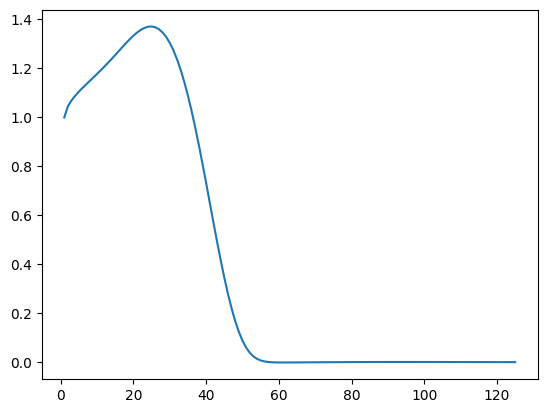

In [21]:
plt.plot(np.linspace(1,125,125), distr_np)

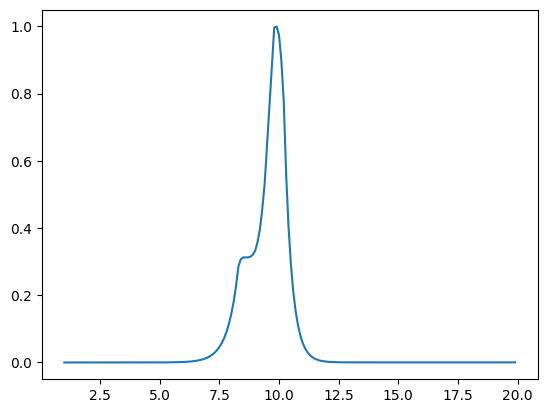

In [22]:
plt.plot(e, spec_np)